In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 4 2024

@author: Yaning
Suggested by Sarah
"""

import torch
import pyro
import math
import pandas as pd
from pyro.distributions import Normal, Bernoulli, Gamma
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning
from pyro import poutine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean 

# %run Documents/pyro_models/data_analysis_without_version.ipynb
%run Documents/pyro_models/multi_agent_simulation.py

In [2]:
# prior mean 0
# prior variance 3
# estimation variance (uncertainty) .5 but change with delay
mean_u_list = [torch.tensor(3.)]
sigma_u_list = [torch.tensor(6.)]
sigma_es_list = [torch.tensor(3.)]
beta_list = [torch.tensor(0.8)]

# initialise trial combinations
repetition = 10
real_delays = [1., 3., 7., 13., 24., 32., 45., 58., 75., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [5.]
# LL values by percentage of SS
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]

In [3]:
environment = Environment(SS_values, LL_values_p, delays, repetition)
# run function returns first parameter list then inference list
parameters_list, inference_list = run(mean_u_list, sigma_u_list, sigma_es_list, beta_list, environment)

In [4]:
inference_list = np.squeeze(inference_list)
parameters_list = np.squeeze(parameters_list)

In [5]:
actions = torch.tensor(inference_list[0])
delays = torch.tensor(inference_list[1])
ss_values = torch.tensor(inference_list[2])
ll_values = torch.tensor(inference_list[3])

In [6]:
inference_list

array([[ 0.  ,  0.  ,  1.  , ...,  1.  ,  0.  ,  1.  ],
       [ 0.1 ,  0.1 ,  0.1 , ..., 12.2 , 12.2 , 12.2 ],
       [ 5.  ,  5.  ,  5.  , ...,  5.  ,  5.  ,  5.  ],
       [ 5.25,  5.25,  5.25, ..., 19.25, 19.25, 19.25]])

In [7]:
# MCMC model
# simulate parameters:
# mean_u 0
# var_u 3
# var_es 0.5

def model(actions, delays, ss_values, ll_values):
    mean_u = pyro.sample("mean_u", Normal(loc = torch.tensor(0.), scale = torch.tensor(2.)))
    log_sigma_u = pyro.sample("log_sigma_u", Normal(torch.tensor(1.), torch.tensor(2.)))
    log_sigma_es = pyro.sample("log_sigma_es", Normal(torch.tensor(2.), torch.tensor(1.)))
    # sigma_u = pyro.sample("sigma_u", Gamma(torch.tensor(1.), torch.tensor(2.)))
    # sigma_es = pyro.sample("sigma_es", Gamma(torch.tensor(2.), torch.tensor(1.)))
    beta = pyro.sample("beta", Gamma(torch.tensor(1.), torch.tensor(2.)))
    num = actions.shape[0]
    e_vals = []
    # for i, actions, delays, ss_values, ll_values in zip(range(len(actions)), actions, delays, ss_values, ll_values):
    #     # with pyro.plate("num", num):
    #     e = (mean_u*delays*var_es + ll_values*var_u)/(delays*var_es + var_u)
    #     p = torch.nn.functional.softmax(torch.tensor([e, ss_values]), dim = 0)[0]
    #     return pyro.sample("obs", Bernoulli(probs = p), obs=actions)
    with pyro.plate("num", num):
        sigma_u = torch.exp(log_sigma_u)
        sigma_es = torch.exp(log_sigma_es)
        e_vals.append((mean_u*delays*sigma_es + ll_values*sigma_u)/(delays*sigma_es + sigma_u))
        softmax_args = torch.stack([beta*e_vals[-1], beta*ss_values])
        p = torch.softmax(softmax_args, dim = 0)[0]
        return pyro.sample("obs", Bernoulli(probs = p), obs=actions)
# pyro.render_model(model, model_args=(actions, delays, ss_values, ll_values), render_params=True, render_distributions=True)



mcmc_kernel = NUTS(model)                                               # initialize proposal distribution kernel
mcmc = MCMC(mcmc_kernel, num_samples=300, num_chains = 3, warmup_steps=50)  # initialize MCMC class
mcmc.run(actions, delays, ss_values, ll_values)

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/350 [00:00, ?it/s]

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torc

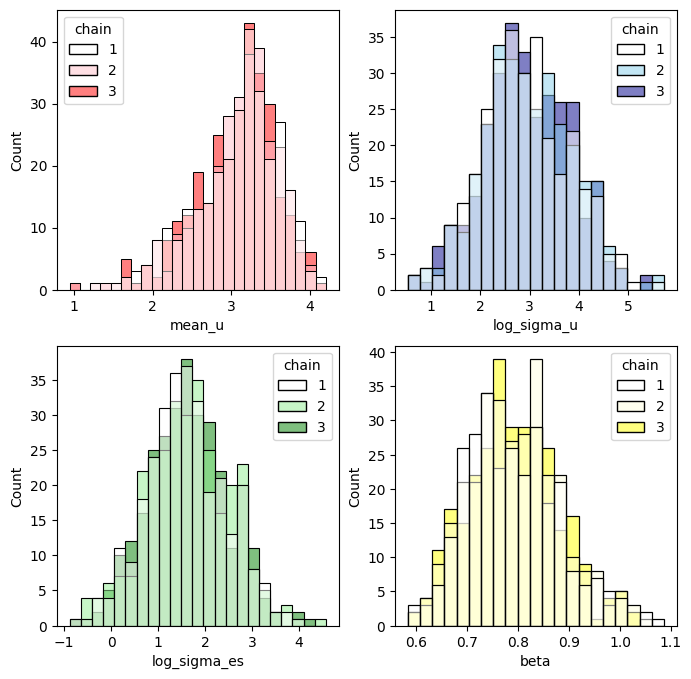

In [9]:
# mcmc.summary()
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

mean_u = pd.DataFrame(mcmc.get_samples()['mean_u'],columns=['mean_u'])
mean_u['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=mean_u, x='mean_u',hue='chain', palette=['white', 'pink', 'red'], ax=axs[0,0])

log_sigma_u = pd.DataFrame(mcmc.get_samples()['log_sigma_u'],columns=['log_sigma_u'])
log_sigma_u['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=log_sigma_u, x='log_sigma_u',hue='chain', palette=['white', 'skyblue', 'darkblue'], ax=axs[0,1])

log_sigma_es = pd.DataFrame(mcmc.get_samples()['log_sigma_es'],columns=['log_sigma_es'])
log_sigma_es['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=log_sigma_es, x='log_sigma_es',hue='chain', palette=['white', 'lightgreen', 'green'], ax=axs[1,0])

beta = pd.DataFrame(mcmc.get_samples()['beta'],columns=['beta'])
beta['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=beta, x='beta',hue='chain', palette=['white', 'lightyellow', 'yellow'], ax=axs[1,1])

plt.show()

In [ ]:
parameters_list